In [ ]:
ACCESS_KEY = '' # In order to use the AWS serice you need to get key id an secret keyfrom Amazon Account
SECRET_KEY = ''

In [ ]:
!apt-get update
!sudo apt install tesseract-ocr
!pip install pytesseract

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu bionic-sec

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytesseract
import PIL.Image
from pytesseract import image_to_data, Output
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image
import cv2 as cv
import numpy as np
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/000ABTT/RUBICONMD /Data/" # Linqing's drive path

### **Extracting text and performing image preprocessing based on an accuracy score threshold**

**Compare Pytessaract with EasyOCR to see which one does better and and the result suggests that Pytessaract performs a bit better and faster at 0.93 compared to 0.85 from Easy OCR.**

**We will set a THRESHOLD for the confidence score to decide if it's good enough to move on to AWS model. If not, perform image preprocessing and compare it to the confidence score before. If better but still below 0.90, try EasyOCR and compare 3 scores together.**

In [ ]:
# a helper function with regex to clean text
def clean(x):
  clean_x = re.sub(r'[^a-zA-Z0-9]+', '', x)
  return clean_x

# Create a dataframe, store all the output of one pdf into a sum dataframe

def read_pdf(path):

  # columns = ["level", "page_num","block_num",	"par_num", "line_num",	"word_num",	"left",	"top",	"width",	"height",	"conf",	"text"]
  # df = pd.DataFrame(columns=columns)
  page_num = len(convert_from_path(path, fmt="PNG"))
  image = convert_from_path(path, fmt="PNG")[0]
  df = pytesseract.image_to_data(image, output_type='data.frame')
  if page_num == 1:
    return df
  else:
    for page in range(1, page_num):
      image = convert_from_path(path, fmt="PNG")[page]
      df2 = pytesseract.image_to_data(image, output_type='data.frame')
      df.append(df2)
    return df

"""
Define a preprocessing function to extract text based on the type of input file (images or pdfs)
"""

def preprocessing(path, threshold):
  extension = path[-3:]

  if extension == 'pdf':
    img = convert_from_path(path, fmt='PNG')[0]
    img = np.array(img)   # change type to np array from PIL image so that it works for smoothening after
  else:
    img = cv.imread(path)

  ocr_result_df = pytesseract.image_to_data(img, output_type='data.frame')  # convert image to text

  ocr_mean = ocr_result_df.conf.mean()

  print("Shape of this data frame: " + str(ocr_result_df.shape))
  ocr_result_df = ocr_result_df[(ocr_result_df.conf != -1) & (ocr_result_df.text != ' ')]
  print("Shape of the data frame after removing cells with no text detected (-1): " + str(ocr_result_df.shape))
  print("The mininum score: " + str(ocr_result_df.conf.min()))
  print("The maximum core: " + str(ocr_result_df.conf.max()))
  print("The mean score: " + str(ocr_mean))

  df_to_be_returned = ocr_result_df

  # check if the text extraction accuracy meets the threshold
  if ocr_mean < OCR_ACC_THRESHOLD:
    print("The mean accuracy score is below the threshold of " + str(OCR_ACC_THRESHOLD) +", so now try image preprocessing.")
    # denoising of image saving it into dst image
    dst = cv.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
    #text_dst = pytesseract.image_to_string(dst)
    #text_dst = text_dst.replace('\n', '')
    text_dst_df = pytesseract.image_to_data(dst, output_type='data.frame')
    text_dst_df = text_dst_df[(text_dst_df.conf != -1) & (text_dst_df.text != ' ')]
    print("The new mininum score: " + str(text_dst_df.conf.min()))
    print("The new maximum core: " + str(text_dst_df.conf.max()))
    print("The new average confidence score after smoothening the image: " + str(text_dst_df.conf.mean()))

    if ocr_mean < text_dst_df.conf.mean(): # check again if the smoothening method actually helps
      df_to_be_returned = text_dst_df
  else:
    print("Image preprocessing is not useful here. Use the default extraction instead.")

  df_to_be_returned['text_clean'] = df_to_be_returned['text'].apply(clean)

  return list(df_to_be_returned.text), df_to_be_returned


In [ ]:
#from os import nice
# Approach: use image_to_data instead to obtain statistics of each word, then take the mean score of words
# to obtain line's confidence score

OCR_ACC_THRESHOLD = 95.0

sample_test_result = f'{file_path}Copy of Sample_EKG.jpeg'
nicer_pdf = f'{file_path}AAA Physician AI Research Opportunity!!!.pdf'
copy_lab_report_pdf = f'{file_path}Copy of Sample_LabReport.pdf'
sample_xray_image = f'{file_path}Copy of Sample_XRay.jpg'
ARXIV_V5_CHESTXRAY_pdf = f'{file_path}ARXIV_V5_CHESTXRAY.pdf'
README_CHESTXRAY_pdf = f'{file_path}README_CHESTXRAY.pdf'


data, data_df = preprocessing(nicer_pdf, OCR_ACC_THRESHOLD)

Shape of this data frame: (551, 12)
Shape of the data frame after removing cells with no text detected (-1): (463, 12)
The mininum score: 0
The maximum core: 97
The mean score: 78.55535390199637
The mean accuracy score is below the threshold of 95.0, so now try image preprocessing.
The new mininum score: 0
The new maximum core: 97
The new average confidence score after smoothening the image: 93.62554112554112


In [ ]:
data_df.head(10)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,text_clean
4,5,1,1,1,1,1,1362,208,69,16,75,"SERVICES,",SERVICES
6,5,1,1,1,2,1,1323,216,33,28,18,os,os
7,5,1,1,1,2,2,1437,220,25,25,4,84,84
9,5,1,1,1,3,1,1307,238,19,23,68,=,
13,5,1,2,1,1,1,515,271,193,41,95,Radiology,Radiology
14,5,1,2,1,1,2,722,271,70,32,96,and,and
15,5,1,2,1,1,3,811,271,151,41,96,Imaging,Imaging
16,5,1,2,1,1,4,979,271,177,32,96,Sciences,Sciences
17,5,1,2,1,1,5,1292,264,20,53,0,F,F
19,5,1,2,1,2,1,416,322,156,32,96,National,National


### **Text processing with NLTK**

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Removing stop words, punctuations, POS Tagging and Lemmatization**



In [ ]:
def text_processing(data):
  # stop_words = set(stopwords.words('english'))
  stop_words = stopwords.words('english')

  # add new stopwords to the list
  stop_words.extend(["could","though","would","also","many",'much'])

  #word_tokens = word_tokenize(data)
  word_tokens = []
  for token in data:
    # remove any value that are not alphanumerical
    new_token = re.sub(r'[^a-zA-Z0-9]+', '', token)
    if new_token != "":
      word_tokens.append(new_token)

  # Remove the stopwords from the list of tokens
  filtered_tokens = [w for w in word_tokens if not w.lower() in stop_words]

  print("List of words before filtering: ")
  print(word_tokens)
  print("List of words after filtering: ")
  print(filtered_tokens)
  print('Word count: ' + str(len(word_tokens)))
  print('Word count after filtering: ' + str(len(filtered_tokens)))

  data_tagset = nltk.pos_tag(filtered_tokens)
  df_tagset = pd.DataFrame(data_tagset, columns=['Word', 'Tag'])

  # Create lemmatizer object
  lemmatizer = WordNetLemmatizer()
  # Lemmatize each word and display the output
  lemmatize_text = []
  for word in filtered_tokens:
    output = [word, lemmatizer.lemmatize(word, pos='n'), lemmatizer.lemmatize(word, pos='a'), lemmatizer.lemmatize(word, pos='v')]
    lemmatize_text.append(output)
  # create DataFrame using original words and their lemma words
  df = pd.DataFrame(lemmatize_text, columns =['Word', 'Lemmatized Noun', 'Lemmatized Adjective', 'Lemmatized Verb'])

  df['Tag'] = df_tagset['Tag']

  # replace with single character for simplifying
  df = df.replace(['NN','NNS','NNP','NNPS'],'n')
  df = df.replace(['JJ','JJR','JJS'],'a')
  df = df.replace(['VBG','VBP','VB','VBD','VBN','VBZ'],'v')

  # define a function where take the lemmatized word when tagset is noun, and take lemmatized adjectives when tagset is adjective

  df_lemmatized = df.copy()
  df_lemmatized['Tempt Lemmatized Word']=df_lemmatized['Lemmatized Noun'] + ' | ' + df_lemmatized['Lemmatized Adjective']+ ' | ' + df_lemmatized['Lemmatized Verb']
  df_lemmatized.head(5)
  lemma_word = df_lemmatized['Tempt Lemmatized Word']
  tag = df_lemmatized['Tag']
  i = 0
  new_word = []
  while i<len(tag):
      words = lemma_word[i].split('|')
      if tag[i] == 'n':
          word = words[0]
      elif tag[i] == 'a':
          word = words[1]
      elif tag[i] == 'v':
          word = words[2]
      new_word.append(word)
      i += 1
  df_lemmatized['Lemmatized Word'] = new_word
  data_string = " ".join(df_lemmatized['Lemmatized Word'].unique())

  print("Word count after lemmatization: " + str(len(df_lemmatized['Lemmatized Word'].unique())))
  return data_string, df_lemmatized


In [ ]:
OCR_ACC_THRESHOLD = 95.0

sample_test_result = f'{file_path}Copy of Sample_EKG.jpeg'
nicer_pdf = f'{file_path}AAA Physician AI Research Opportunity!!!.pdf'
copy_lab_report_pdf = f'{file_path}Copy of Sample_LabReport.pdf'
sample_xray_image = f'{file_path}Copy of Sample_XRay.jpg'
ARXIV_V5_CHESTXRAY_pdf = f'{file_path}ARXIV_V5_CHESTXRAY.pdf'
README_CHESTXRAY_pdf = f'{file_path}README_CHESTXRAY.pdf'

img_path = copy_lab_report_pdf

data, data_df = preprocessing(img_path, OCR_ACC_THRESHOLD)

print("-----------------------------------------------------")

data_string, lemmatized_df = text_processing(data)
# returned data needs to be one string to be used in AWS
# data_string is input for AWS in next step

Shape of this data frame: (448, 12)
Shape of the data frame after removing cells with no text detected (-1): (377, 12)
The mininum score: 4
The maximum core: 97
The mean score: 77.64508928571429
The mean accuracy score is below the threshold of 95.0, so now try image preprocessing.
The new mininum score: 0
The new maximum core: 97
The new average confidence score after smoothening the image: 90.21148825065274
-----------------------------------------------------
List of words before filtering: 
['From', 'unknown', 'Page', '44', 'Date', '12282016', '355', '17', 'PM', 'Page', '004', 'Alpha', 'Beta', 'Medical', 'Center', 'Laboratory', 'Ashland', 'Campus', 'SURGICAL', 'PATHOLOGY', 'REPORT', 'Patient', 'SANDBERG', 'KATIE', 'Specimen', 'ABS1600001', 'The', 'immunoperoxidase', 'stamns', 'reported', 'above', 'was', 'developed', 'and', 'its', 'performance', 'charactensties', 'determined', 'by', 'Pathologics', 'Services', 'Inc', 'Berkeley', 'CA', 'It', 'has', 'not', 'been', 'cleared', 'or', 'app

In [ ]:
data_df # this df is used to retrieve the location of the words (potential PHI according to AWS model) on the image, for redaction.

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,text_clean
4,5,1,1,1,1,1,493,4,55,20,73,From.,From
5,5,1,1,1,1,2,565,5,97,19,74,unknown,unknown
6,5,1,1,1,1,3,720,4,56,25,95,Page,Page
7,5,1,1,1,1,4,790,5,34,18,95,4/4,44
8,5,1,1,1,1,5,880,4,51,20,94,Date,Date
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,5,1,14,1,1,12,984,2278,126,21,96,"information,",information
450,5,1,14,1,1,13,1120,2279,42,18,84,visit,visit
451,5,1,14,1,1,14,1177,2278,40,23,30,http,http
452,5,1,14,1,1,15,1224,2278,70,19,30,//Awww,Awww


### **AWS Comprehend Medical**

In [ ]:
!pip install presidio-image-redactor
!pip install botocore boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from botocore.vendored import requests
import json
import boto3
import logging
import threading
client = boto3.client(region_name='us-east-1', service_name='comprehendmedical', aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)

def extract_entities_from_message(message):
    return client.detect_phi(Text=message)

#calling API, returned object is a dictionary of words that's classified as PHI and their confidence scores.
result = extract_entities_from_message(data_string)

In [ ]:
result

{'Entities': [{'Id': 1,
   'BeginOffset': 56,
   'EndOffset': 104,
   'Score': 0.24228699505329132,
   'Text': 'Laboratory  Ashland  Campus  SURGICAL  PATHOLOGY',
   'Category': 'PROTECTED_HEALTH_INFORMATION',
   'Type': 'ADDRESS',
   'Traits': []},
  {'Id': 2,
   'BeginOffset': 123,
   'EndOffset': 138,
   'Score': 0.6523721218109131,
   'Text': 'SANDBERG  KATIE',
   'Category': 'PROTECTED_HEALTH_INFORMATION',
   'Type': 'NAME',
   'Traits': []},
  {'Id': 3,
   'BeginOffset': 150,
   'EndOffset': 160,
   'Score': 0.6089950799942017,
   'Text': 'ABS1600001',
   'Category': 'PROTECTED_HEALTH_INFORMATION',
   'Type': 'ID',
   'Traits': []},
  {'Id': 4,
   'BeginOffset': 248,
   'EndOffset': 269,
   'Score': 0.31890633702278137,
   'Text': 'Pathologics  Services',
   'Category': 'PROTECTED_HEALTH_INFORMATION',
   'Type': 'ADDRESS',
   'Traits': []},
  {'Id': 5,
   'BeginOffset': 271,
   'EndOffset': 284,
   'Score': 0.453013151884079,
   'Text': 'Inc  Berkeley',
   'Category': 'PROTECTED_

In [ ]:
result['Entities'][0]

{'Id': 1,
 'BeginOffset': 56,
 'EndOffset': 104,
 'Score': 0.24228699505329132,
 'Text': 'Laboratory  Ashland  Campus  SURGICAL  PATHOLOGY',
 'Category': 'PROTECTED_HEALTH_INFORMATION',
 'Type': 'ADDRESS',
 'Traits': []}

In [ ]:
# set a baseline for the score to determine if it should be considered a PHI
PHI_THRESHOLD = 0.5   # needs revision
list_redact = []      # a list that holds all words to be redacted

# convert the result dictionary into a data frame
PHI_text_score = pd.DataFrame.from_dict(result['Entities'])

# if the length of the 'Entities' in the returned dictionary is 0 or the max score doesn't exceed the threshold,
# is it safe to conclude that there is no PHI/PII in the file?
if len(PHI_text_score) == 0 or PHI_text_score.Score.max() < PHI_THRESHOLD:
  print("There is no PHI/PII detected in the file.")
  # end of process

else:  # perform redaction for the ones with score higher than the baseline
  for i in PHI_text_score.index:
    if PHI_text_score['Score'][i] > PHI_THRESHOLD:
      #print("This entity needs to be redacted: " + str(PHI_text_score['Text'][i]))
      list_redact.append(PHI_text_score['Text'][i].split()) # I noticed that AWS will return a group of words that seem to link together,
      # so here I split them for the redaction process after as it will redact one word at a time
  list_redact = [item for sublist in list_redact for item in sublist] # flatten the list
list_redact

['SANDBERG', 'KATIE', 'ABS1600001', 'Ellen', 'Barns', 'http', 'Awww', 'gficom']

###**Locating and bordering words for the redaction process**
**Draw Rectangle box on the image**

#### create a sample data of the tesseract output dataframe example

In [ ]:
file_path_output = "/content/drive/MyDrive/000ABTT/RUBICONMD /Output Folder/PDF output/" # Linqing's drive path output

In [ ]:
image_path = img_path
store_path = file_path_output
df = data_df

In [ ]:


def cover_text_pdf_or_image(path, store_path, df, list_redact, color='blue', width=2):
  # path - the file path of the pdf or image currently reading
  # store_path - the path where you want to store the redacted image
  # df - the dataframe you have all the result data and a column call "text_clean" that cotains the list_redact words
  # list_redact - list of information you want to cover in the image
  extention = os.path.splitext(path)[1]
  if extention =='.jpg' or extention =='.png' or extention =='jpeg':
    image = Image.open(path)
    draw = ImageDraw.Draw(image)
    try:
      for word in list_redact:
          (x, y, w, h) = (df.loc[df['text_clean'] == word, 'left'], df.loc[df['text_clean'] == word, 'top'], df.loc[df['text_clean'] == word, 'width'], df.loc[df['text_clean'] == word, 'height'])
          draw.rectangle((x, y, x + w, y + h), fill=color, width=width)
      file_name = os.path.splitext(os.path.basename(path))[0] # get the name of the pdf which it will be folder name to store images
      if not os.path.exists(store_path):
          return f"invaild path{store_path}"
      # get the original name of the image
      print(f"image will be stored at {store_path} with file name {file_name}_redacted.jpg ")
      image.save(f'/{store_path}/{file_name}_redacted.jpg', 'JPEG') # save the image into folderwith the pdf name as JPEG
    except:
      return f"error on reading this image {path}"
  elif extention ==".pdf": # if the file is pdf then loop through each page, find the df realte with that image, and thecn do redaction, store image into a folder
    page_num = len(convert_from_path(path, fmt="PNG"))
    # print(page_num)
    for page in range(page_num):
      image = convert_from_path(path, fmt="PNG")[page]
      df_page = df[df['page_num'] == page+1]
      if df_page.shape[0] == 0:
        pass
      else:
        draw = ImageDraw.Draw(image)
        for word in list_redact:
          (x, y, w, h) = (df_page.loc[df['text_clean'] == word, 'left'], df_page.loc[df['text_clean'] == word, 'top'], df_page.loc[df['text_clean'] == word, 'width'], df_page.loc[df['text_clean'] == word, 'height'])
          draw.rectangle((x, y, x + w, y + h), fill=color, width=width)
      folder_name = os.path.splitext(os.path.basename(path))[0] # get the name of the pdf which it will be folder name to store images
      output_path = os.path.join(store_path, folder_name)
      if not os.path.exists(output_path):
          os.mkdir(output_path)
      # get the original name of the image
      print(f"image will be stored at {output_path} with file name {folder_name}_page_{page_num}.jpg ")
      image.save(f'/{output_path}/{folder_name}_page_{page_num}.jpg', 'JPEG') # save the image into folderwith the pdf name as JPEG
    pdf_folder = os.path.join(store_path, os.path.splitext(os.path.basename(path))[0])
    combine_images_to_one_pdf(pdf_folder, store_path)
  else:
    return f"{path} is not a image or pdf file"
  return image

In [ ]:
# combine all the images in a folder combine_images_to_pdf
import os
from PIL import Image, ImageDraw

def combine_images_to_one_pdf(image_folder_path, pdf_store_path):
  if not os.path.exists(image_folder_path):
      return f"image_folder_path {image_folder_path} path is not right"
  if not os.path.exists(pdf_store_path):
      return f"pdf_store_path {pdf_store_path} path is not right"
  try:
    images = os.listdir(image_folder_path) #loop throught all the files in the path
    image_list =[]
    for file in images:
        # make sure file is an image
        # print(file)
        if file.endswith(('.jpg', '.png', 'jpeg')):
            image_path = os.path.join(image_folder_path, file)
            image_list.append(Image.open(image_path).convert('RGB'))#f'{image_path}/{file}'
    current_folder = os.path.basename(os.path.normpath(image_folder_path))
    out_pdf_path = f"{pdf_store_path}{current_folder}_combine_pdf.pdf"
    image_list[0].save(out_pdf_path, save_all=True, append_images=image_list[1:]) # use the first image in the list and append image togehter into a pdf
    print(f"{images} files are at {image_folder_path}\n")
    print(f"{current_folder}_combine_pdf.pdf combined image to pdf stored at {pdf_store_path}")
    # after combine all images into one pdf, remove the images
    for image in images:
      if image.endswith(('.jpg', '.png', 'jpeg')):
        os.remove(image)

  except:
    return f"Not able to indentfy image in {image_folder_path} folder, maybe restart run time if in colab"

image will be stored at /content/drive/MyDrive/000ABTT/RUBICONMD /Output Folder/PDF output/Copy of Sample_LabReport with file name Copy of Sample_LabReport_page_1.jpg 
['Copy of Sample_LabReport_page_1.jpg'] files are at /content/drive/MyDrive/000ABTT/RUBICONMD /Output Folder/PDF output/Copy of Sample_LabReport

Copy of Sample_LabReport_combine_pdf.pdf combined image to pdf stored at /content/drive/MyDrive/000ABTT/RUBICONMD /Output Folder/PDF output/


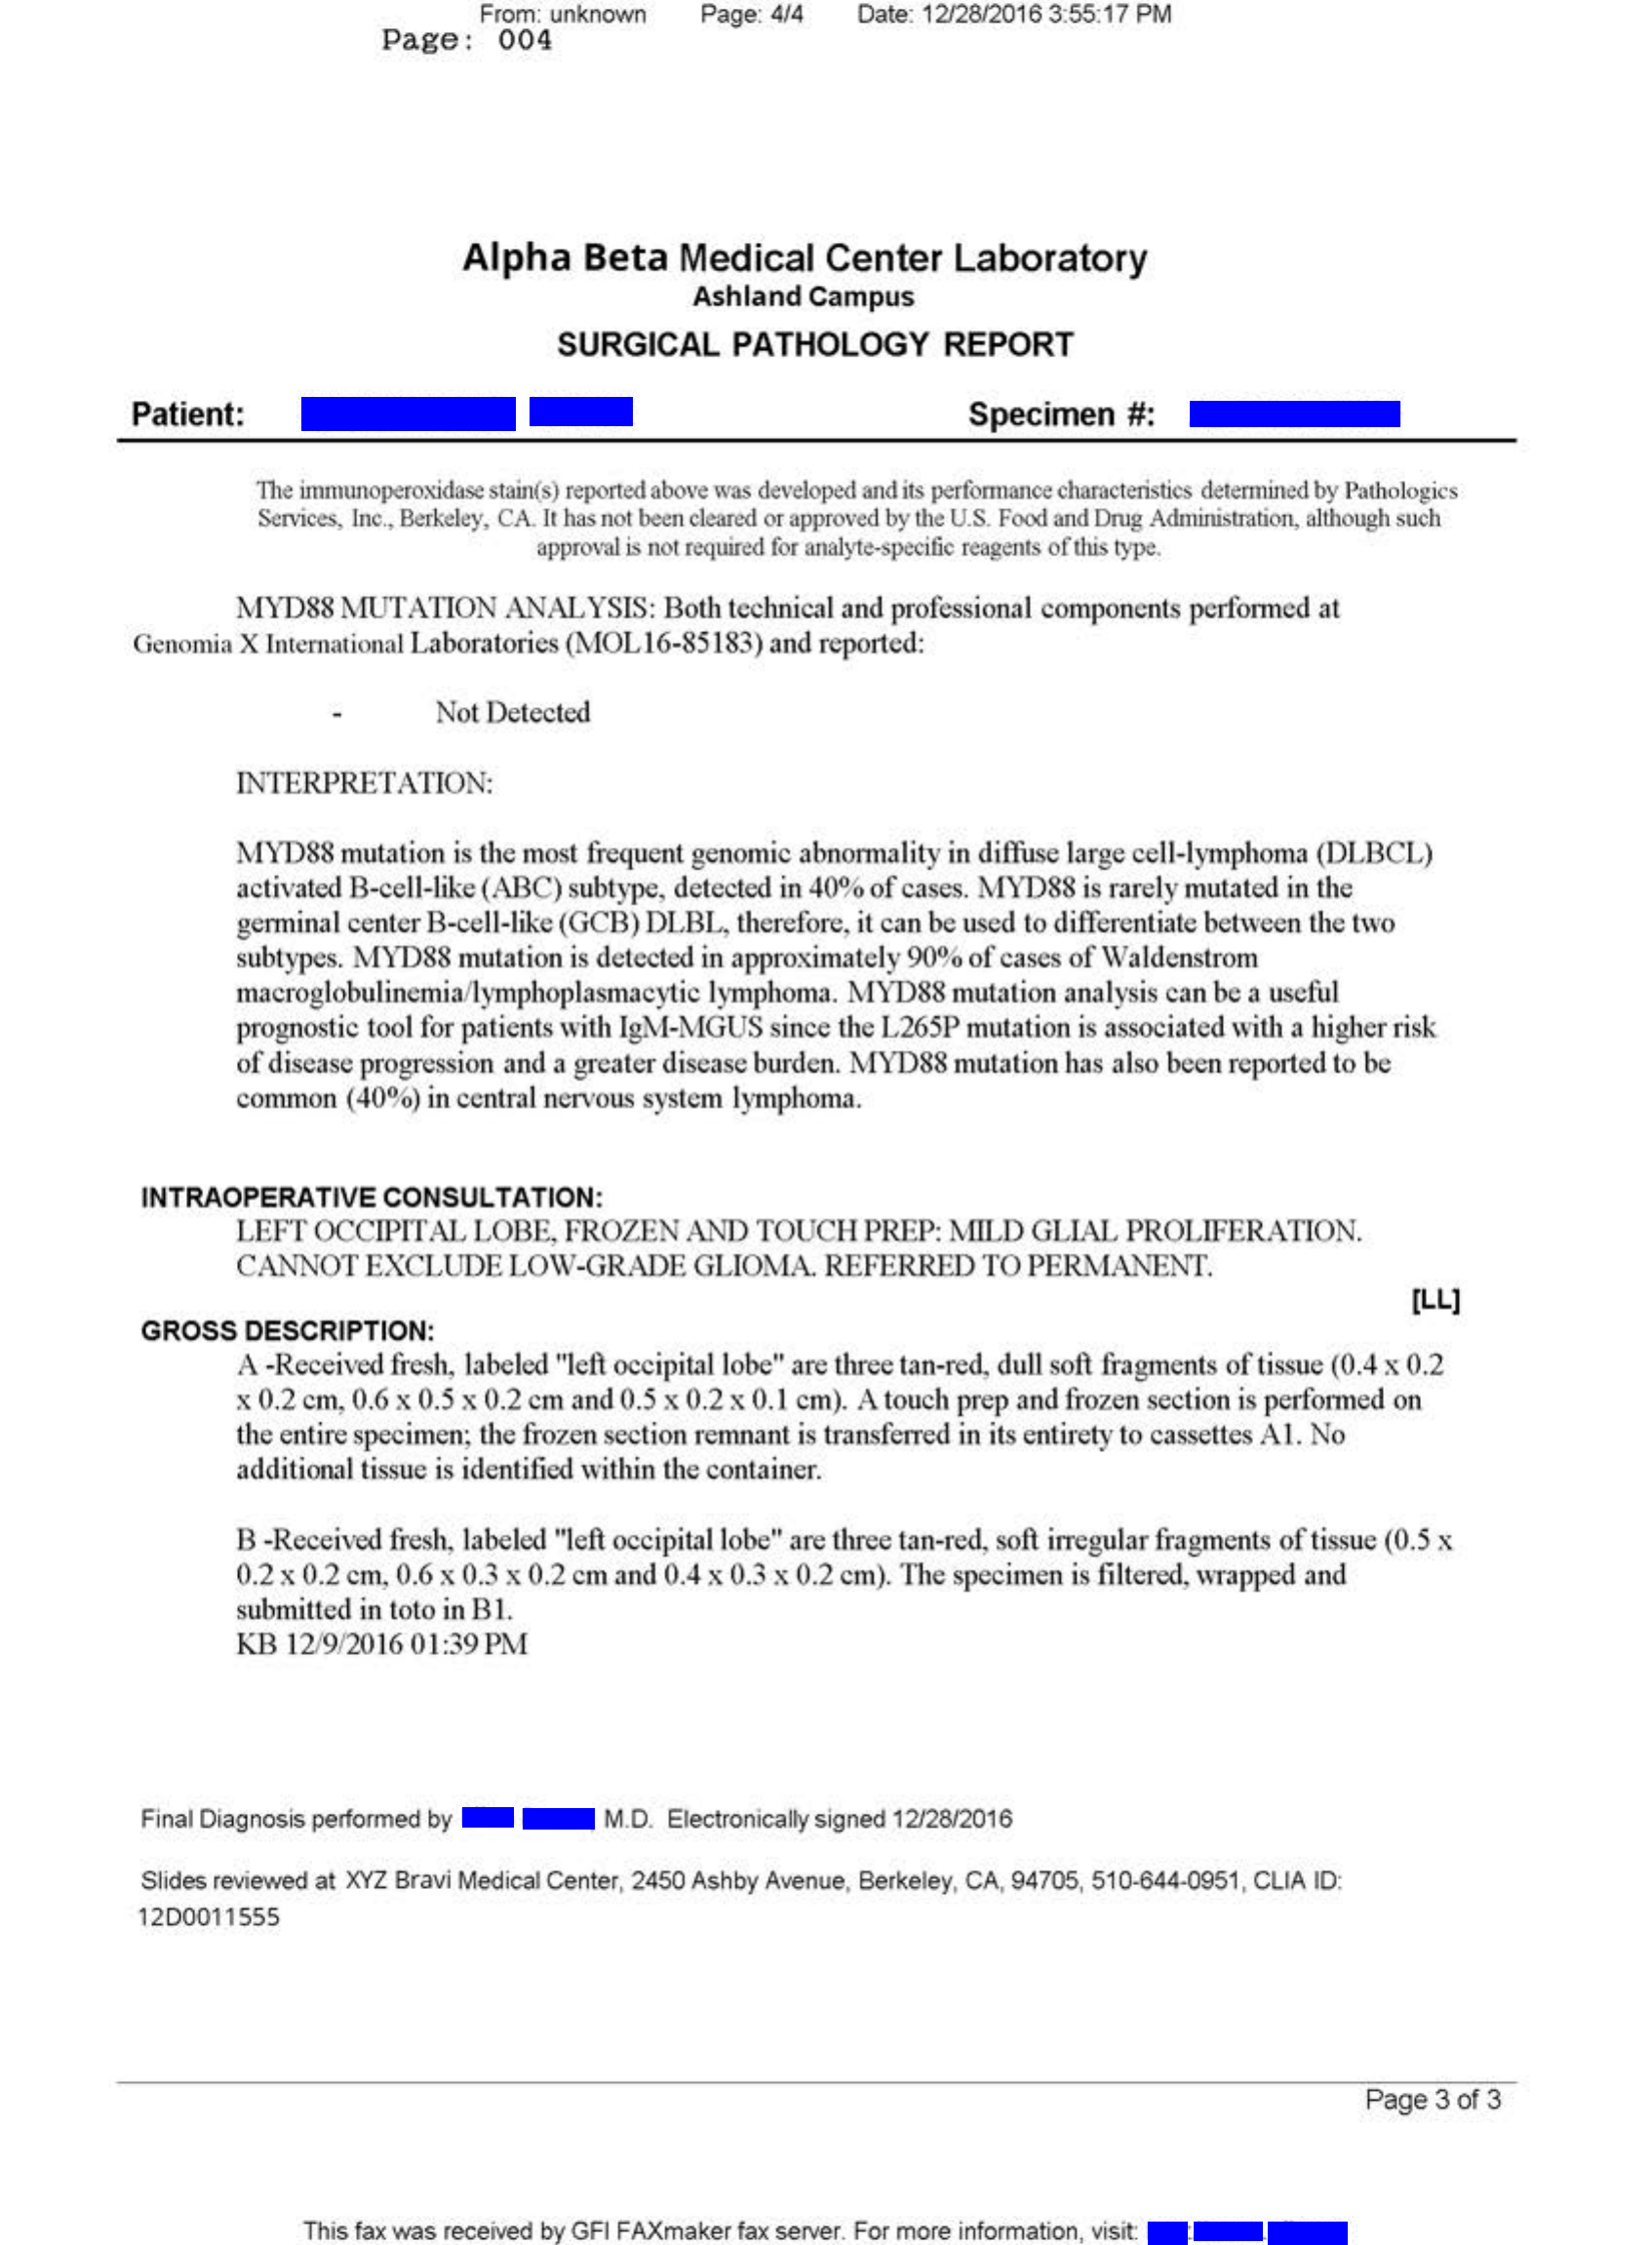

In [ ]:
cover_text_pdf_or_image(image_path, store_path, df, list_redact)